## Load Data

In [1]:
%matplotlib inline
import numpy as np
from os import path
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def change_plot_size(width, height, plt):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = width
    fig_size[1] = height
    plt.rcParams["figure.figsize"] = fig_size
    plt.rcParams['xtick.direction'] = 'out'
    
change_plot_size(20, 6, plt)

In [3]:
def load_dataset(dataset_name, dataset_folder):
    dataset_path = path.join(dataset_folder, dataset_name)
    train_file_path = path.join(dataset_path, '{}_TRAIN.tsv'.format(dataset_name))
    test_file_path = path.join(dataset_path, '{}_TEST.tsv'.format(dataset_name))

    #training and test data
    train = pd.read_csv(train_file_path, sep='\t', header = None)
    test = pd.read_csv(test_file_path, sep='\t', header = None)
    X_test_0 = test[test.iloc[:, 0] == 2].iloc[:, 1:]
    X_test_1 = test[test.iloc[:, 0] == 1].iloc[:, 1:]
    X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
    X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]

    return X_train, y_train, X_test, y_test, X_test_0, X_test_1

In [4]:
X_train, y_train, X_test, y_test, X_test_0, X_test_1 = load_dataset('TwoLeadECG', 'datasets')

In [5]:
X_train.shape

(23, 82)

## Time Series

In [6]:
#create ts class 1
X_test_1 = X_test_1.assign(NaN=np.nan) #remove artificial patterns
ts_1 = X_test_1.iloc[0, :]
for i in range(1, 25): ts_1 = ts_1.append(X_test_1.iloc[i, :])

#create ts class 0
X_test_0 = X_test_0.assign(NaN=np.nan)
ts_0 = X_test_0.iloc[0, :]
for i in range(1, 25): ts_0 = ts_0.append(X_test_0.iloc[i, :])

In [7]:
ts_1.shape, ts_0.shape

((2075,), (2075,))

In [8]:
#mix the two ts
cutoff = int(len(ts_1)/2)
SampleTarget = np.concatenate((ts_1[:cutoff], ts_0, ts_1[cutoff:]))
SampleTarget.shape

(4150,)

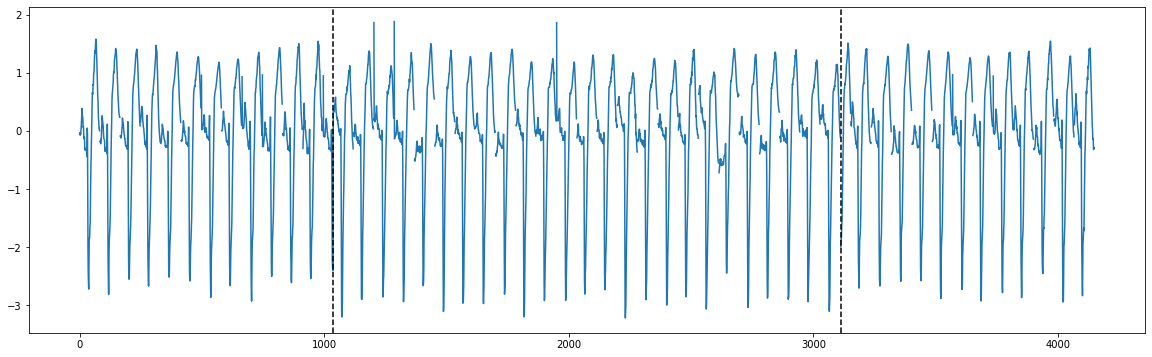

In [9]:
#plot cutoff between classes
plt.plot(SampleTarget)
plt.axvline(x=cutoff, linestyle="dashed", color = 'black')
plt.axvline(x=cutoff + len(ts_0), linestyle="dashed", color = 'black')

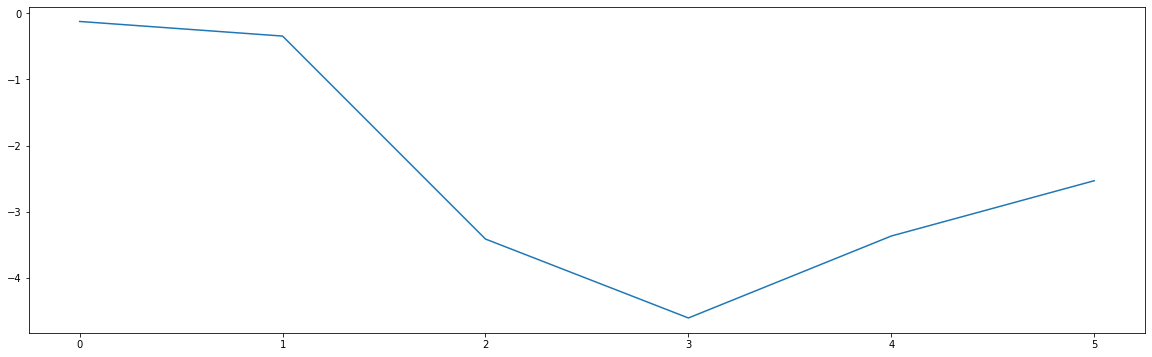

In [10]:
#query subsequence from shapelet file
shapl_path = path.join('datasets', 'TwoLeadECG', 'shapelets.csv')
shapl_df = pd.read_csv(shapl_path)
Pattern = shapl_df.iloc[3, 1:]

plt.plot(Pattern)

## Distance Profile

In [11]:
from stumpy.core import mass
distance_profile = mass(Pattern, SampleTarget)
distance_profile[distance_profile == np.inf] = np.nan
distance_profile.shape

(4145,)

In [12]:
np.sort(distance_profile)

array([0.54352915, 0.65346958, 0.66358873, ...,        nan,        nan,
              nan])

In [13]:
min_idx = np.nanargmin(distance_profile)
distance_profile[min_idx]

0.5435291543272716

In [14]:
min_idxs = np.argpartition(distance_profile, 2)[:2]
distance_profile[min_idxs]

array([0.54352915, 0.65346958])

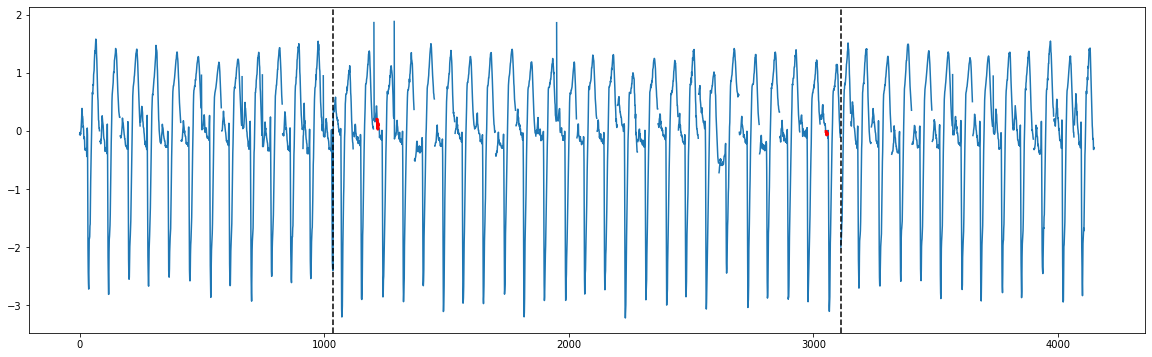

In [15]:
m = len(Pattern)
plt.plot(SampleTarget)
for i in range(2):
    plt.plot(
        list(range(min_idxs[i], (min_idxs[i] + m))),
        SampleTarget[min_idxs[i] : (min_idxs[i] + m)],
        "r",
        linewidth=3.0,
    )
plt.axvline(x=cutoff, linestyle="dashed", color = 'black')
plt.axvline(x=cutoff + len(ts_0), linestyle="dashed", color = 'black')

Note that the best matches are from the same class

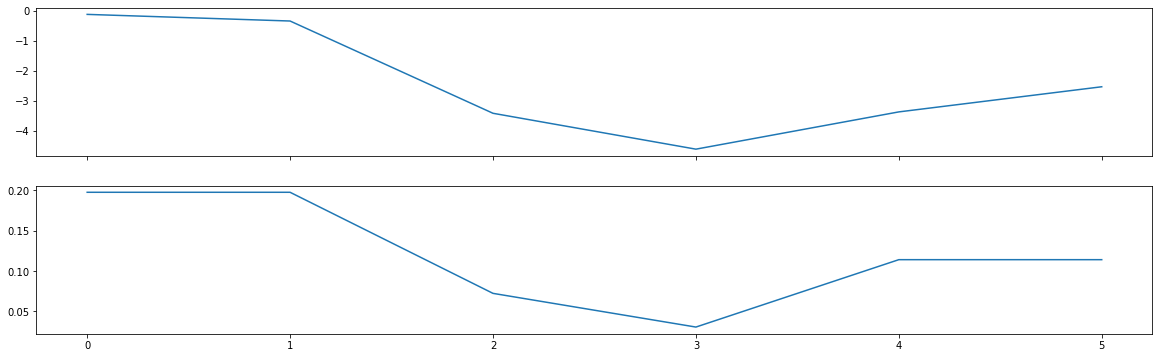

In [16]:
#Plot Best Match
fig, axs = plt.subplots(2, sharex=True)

# pattern
axs[0].plot(Pattern)

# best match
axs[1].plot(SampleTarget[min_idx : (min_idx + m)])